In [43]:
from ephys import core, events
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set up block path
block_path = '/home/brad/krista/B1083/P03S03/'

# load spikes, stimuli, clusters
spikes = core.load_spikes(block_path)
clusters = core.load_clusters(block_path)
trials = events.load_trials(block_path)

In [164]:
def get_average_firing_rate(spikes, cluster_id, t_start, t_end, fs):
    '''
    Compute the average firing rate of the cluster <cluster_id> during the time interval [t_start, t_end]
    Average firing rate is (# of spikes in interval) / (duration of interval)
    '''
    cluster_spikes_in_interval = spikes[(spikes['cluster'] == cluster_id) &
                            (spikes['time_samples'] < t_end) & 
                            (spikes['time_samples'] > t_start)
    ]
    n_spikes = cluster_spikes_in_interval.size
    dt = (t_end - t_start) / fs
    return n_spikes / dt

def get_stimulus_average_firing_rate(spikes, trials, cluster_id, stimulus_id, fs):
    '''
    Return the average firing rate of a neuron over all trials from a given stimulus
    '''
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    avg_fr = 0
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        avg_fr += get_average_firing_rate(spikes , cluster_id, s_start, s_end, fs)
    return avg_fr / stim_trials.size

def get_stimulus_avg_sd_firing_rate(spikes, trials, cluster_id, stimulus_id, fs, interval=[0,1]):
    '''
    Return the mean and standard deviation firing rate of a neuron over all trials from a given stimulus
    '''
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    fr_list=[]
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        int_start = int(s_start + (s_end - s_start)*interval[0])
        int_end = int(s_start + (s_end - s_start)*interval[1])
        fr_list.append(get_average_firing_rate(spikes , cluster_id, int_start, int_end, fs))
        
    return (np.mean(fr_list), np.std(fr_list))

    
def get_pair_stimulus_average_responses(spikes, trials, cluster_a, cluster_b, fs):
    '''
    Get the average responses from all stimuli for a pair of cells
    '''
    
    stimuli = sorted(trials['stimulus'].unique())
    ret = []
    for stim in stimuli:
        cluster_a_avg_response = get_stimulus_average_firing_rate(spikes, trials, cluster_a, stim, fs)
        cluster_b_avg_response = get_stimulus_average_firing_rate(spikes, trials, cluster_b, stim, fs)
        ret.append([cluster_a_avg_response, cluster_b_avg_response])
    return np.array(ret)


### Noise correlation funcs
def get_zscore_responses(spikes, trials, cluster_id, stimulus_id, fs, interval=[0, 1]):
    ''' Return an array of the z-scored responses from each trial for a given stim and cell'''
    
    # get mean and standard deviation response
    degenerate = False
    mu, sig = get_stimulus_avg_sd_firing_rate(spikes, trials, cluster_id, stimulus_id, fs, interval=interval)
    if (sig < 1e-12):
        print("Uh Oh... standard deviation very small")
        print("Cluster: {} Stimulus: {} mu: {} sigma: {}".format(cluster_id, stimulus_id, mu, sig))
        degenerate = True
    
    # for each trial compute z-score
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    stim_clu_zscores = []
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        int_start = int(s_start + (s_end - s_start)*interval[0])
        int_end = int(s_start + (s_end - s_start)*interval[1])
        if degenerate:
            stim_clu_zscores.append(0.0)
        else:
            trial_fr = get_average_firing_rate(spikes, cluster_id, int_start, int_end, fs)
            zscore = (trial_fr - mu)/sig
            stim_clu_zscores.append(zscore)
    return np.array(stim_clu_zscores)
    
def get_stim_zscores(spikes, trials, clusters, stimulus_id, fs, interval=[0, 1]):
    ''' Get an ncell x ntrial array of zscores for a given stim'''
    
    stimulus_zscores = []
    for cluster in clusters:
        stimulus_zscores.append(get_zscore_responses(spikes, trials, cluster, stimulus_id, fs, interval=interval))
    return np.vstack(stimulus_zscores)

def get_all_stim_zscores(spikes, trials, clusters, fs, interval=[0, 1]):
    ''' Return an ncell x ntrial x nstim array of zscores'''
    
    stimuli = sorted(trials['stimulus'].unique())
    all_stim_zscores = []
    for stim in stimuli:
        all_stim_zscores.append(get_stim_zscores(spikes, trials, clusters, stim, fs, interval=interval))
    return np.dstack(all_stim_zscores)
    
def get_pair_noise_correlation(stim_zscores, cluster_a, cluster_b):
    '''
    given an ncell x ntrial array of z-scores, compute the noise correlation between cells index a and index b
    cluster_a is the *index* of the cell, not its id
    '''

    z_a = stim_zscores[cluster_a, :]
    z_b = stim_zscores[cluster_b, :]
    return pearsonr(z_a, z_b)[0]

def get_pair_stim_avg_noise_correlation(all_stim_zscores, cluster_a, cluster_b):
    '''
    For a pair of cells given by *index* cluster_a, cluster_b, compute the noise correlation averaged over all stimuli
    
    '''
    
    nstim = all_stim_zscores.shape[2]
    corrs = []
    for stimnum in range(nstim):
        corrs.append(get_pair_noise_correlation(all_stim_zscores[:, :, stimnum], cluster_a, cluster_b))
    return np.mean(corrs)

def get_all_stim_avg_noise_correlation(all_stim_zscores, clusters):
    ''' Compute the stimulus averaged noise correlation from all pairs of cells
    all_stim_zscores is an ncell x ntrial x nstim array
    
    '''
    
    all_noise_corrs = []
    for pair in tqdm(combinations(range(len(clusters)),2)):
        all_noise_corrs.append(get_pair_stim_avg_noise_correlation(all_stim_zscores, pair[0], pair[1]))
    return np.array(all_noise_corrs)
    
###################################   
## Signal correlations
def get_signal_correlation(spikes, trials, cluster_a, cluster_b, fs):
    ''' Compute the signal correlation for a pair of cells
    
    spikes - spikes dataframe
    trials - trials dataframe containing all the trials for which you wish to compute signal correlations
                (e.g. all the trials from a particular class of stimuli)
    cluster_a - the *cluster id* of the first cell in the pair
    cluster_b - the *cluster id* of the second cell in the pair
    fs - sampling rate
    '''
    
    stim_responses = get_pair_stimulus_average_responses(spikes, trials, cluster_a, cluster_b, fs)
    stim_correlation = pearsonr(stim_responses[:, 0], stim_responses[:, 1])[0]
    return stim_correlation

def get_all_average_responses(spikes, trials, clusters, fs):
    ''' Return an ncell x nstim matrix of trial-averaged firing rate responses 
        spikes - spikes dataframe
        trials - trials dataframe containing all the trials for which you wish to compute signal correlations
                (e.g. all the trials from a particular class of stimuli)
        clusters - list of *cluster ids* for which you wish to compute average responses
                    the output array will have clusters indexed in this order
    '''
    
    stimuli = sorted(trials['stimulus'].unique())
    responses = np.zeros((len(clusters), len(stimuli)))
    for i in tqdm(range(len(clusters))):
        for j in range(len(stimuli)):
            responses[i, j] = get_stimulus_average_firing_rate(spikes, trials, clusters[i], stimuli[j], fs)
    return responses

from tqdm import tqdm
def get_all_signal_correlations(responses, clusters):
    ''' given an ncell x nstim matrix of trial averaged firing rate responses, 
    compute the signal correlations for every pair.
    
    responses - an ncell x nstim matrix of trial averaged firing rate responses
    clusters - array of *cluster ids* corresponding to the order of the rows in the response matrix
    '''
    all_pairs_signal_correlations = []
    for pair in tqdm(combinations(range(len(clusters)), 2)):
        response_a = responses[pair[0], :]
        response_b = responses[pair[1], :]
        pair_sig_corr = pearsonr(response_a, response_b)[0]
        all_pairs_signal_correlations.append(pair_sig_corr)
    return np.array(all_pairs_signal_correlations)

In [166]:
good_clusters = clusters[clusters['quality'] == 'Good']['cluster'].unique()
fs = 30000

responses = get_all_average_responses(spikes, trials, good_clusters, fs)

100%|██████████| 101/101 [00:19<00:00,  5.17it/s]


In [167]:
signal_corrs = get_all_signal_correlations(responses, good_clusters)

5050it [00:00, 18773.61it/s]


(array([  1.,   6.,  14.,  28.,  33.,  51.,  71.,  86., 107., 139., 154.,
        185., 180., 229., 233., 231., 238., 232., 214., 227., 235., 244.,
        237., 195., 222., 214., 188., 186., 176., 146., 124.,  84.,  68.,
         48.,  24.]),
 array([-0.95349373, -0.89802506, -0.84255639, -0.78708772, -0.73161905,
        -0.67615038, -0.62068171, -0.56521304, -0.50974437, -0.4542757 ,
        -0.39880703, -0.34333835, -0.28786968, -0.23240101, -0.17693234,
        -0.12146367, -0.065995  , -0.01052633,  0.04494234,  0.10041101,
         0.15587968,  0.21134835,  0.26681702,  0.32228569,  0.37775436,
         0.43322304,  0.48869171,  0.54416038,  0.59962905,  0.65509772,
         0.71056639,  0.76603506,  0.82150373,  0.8769724 ,  0.93244107,
         0.98790974]),
 <a list of 35 Patch objects>)

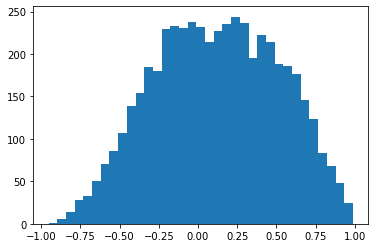

In [168]:
plt.hist(signal_corrs, bins=35)

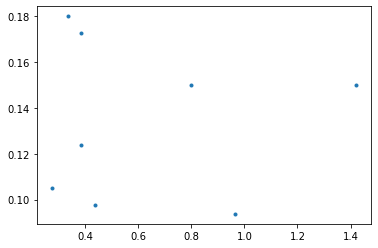

In [39]:
test = get_pair_stimulus_average_responses(spikes, trials, 38, 49, 30000)
plt.plot(test[:, 0], test[:, 1], '.')

In [54]:
clusters[clusters['quality'] == 'Good']['cluster'].unique()

array([  2,   3,   4,   5,   6,   7,   8,   9,  11,  13,  14,  15,  16,
        17,  18,  19,  20,  22,  23,  24,  26,  27,  28,  29,  30,  31,
        33,  34,  35,  36,  38,  39,  41,  42,  43,  44,  45,  46,  47,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  59,  60,  61,  62,
        64,  66,  67,  68,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  82,  83,  84,  85,  86,  88,  89,  90,  91,  92,  94,
        95,  97,  98,  99, 101, 102, 103, 106, 111, 112, 113, 114, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 132, 133], dtype=int32)

In [66]:
from itertools import combinations
len(list(combinations(np.arange(101), 2)))

5050

In [169]:
test=get_all_stim_zscores(spikes, trials, good_clusters, fs)

Uh Oh... standard deviation very small
Cluster: 42 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: J_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 95 Stimulus: J_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: J_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 83 Stimulus: K_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 92 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 103 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 36 

In [170]:
noise_corrs = get_all_stim_avg_noise_correlation(test, good_clusters)

5050it [00:02, 2190.82it/s]


/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  3.,   1.,   4.,   6.,  10.,  12.,  24.,  20.,  30.,  56.,  44.,
         84., 113., 161., 261., 364., 480., 512., 523., 432., 336., 246.,
        139., 107., 102.,  60.,  40.,  32.,  26.,  21.,  14.,   6.,   4.,
          3.,   2.]),
 array([-0.84226617, -0.79402774, -0.74578932, -0.69755089, -0.64931247,
        -0.60107404, -0.55283562, -0.50459719, -0.45635876, -0.40812034,
        -0.35988191, -0.31164349, -0.26340506, -0.21516663, -0.16692821,
        -0.11868978, -0.07045136, -0.02221293,  0.02602549,  0.07426392,
         0.12250235,  0.17074077,  0.2189792 ,  0.26721762,  0.31545605,
         0.36369447,  0.4119329 ,  0.46017133,  0.50840975,  0.55664818,
         0.6048866 ,  0.65312503,  0.70136345,  0.74960188,  0.79784031,
         0.84607873]),
 <a list of 35 Patch objects>)

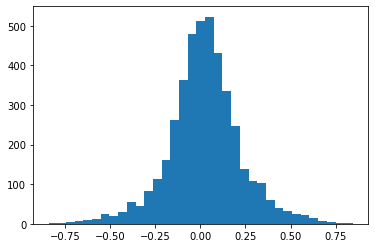

In [171]:
plt.hist(noise_corrs, bins=35)

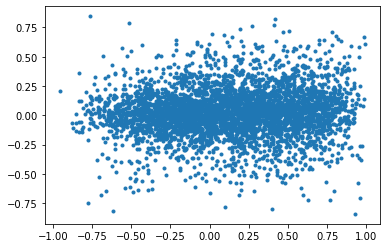

In [172]:
plt.plot(signal_corrs, noise_corrs, '.')

In [173]:
nas = np.logical_or(np.isnan(signal_corrs), np.isnan(noise_corrs))
print(pearsonr(signal_corrs[~nas], noise_corrs[~nas]))

(0.07350344662369467, 1.4890222776831252e-06)


In [133]:
np.isnan(noise_corrs[nas]).any()

True

In [138]:
np.nanmean(noise_corrs)

0.023375862159474507

In [174]:
stimuli = sorted(trials['stimulus'].unique())
fam_stim = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
unfam_stim = ['I_40k', 'J_40k', 'K_40k', 'L_40k']
fam_trials = trials[trials['stimulus'].isin(fam_stim)]
unfam_trials = trials[trials['stimulus'].isin(unfam_stim)]

In [175]:
fam_responses = get_all_average_responses(spikes, fam_trials, good_clusters, fs)
unfam_responses = get_all_average_responses(spikes, unfam_trials, good_clusters, fs)
fam_signal_corrs = get_all_signal_correlations(fam_responses, good_clusters)
unfam_signal_corrs = get_all_signal_correlations(unfam_responses, good_clusters)

fam_zscores = get_all_stim_zscores(spikes, fam_trials, good_clusters, fs)
fam_noise_corrs = get_all_stim_avg_noise_correlation(fam_zscores, good_clusters)
unfam_zscores = get_all_stim_zscores(spikes, unfam_trials, good_clusters, fs)
unfam_noise_corrs = get_all_stim_avg_noise_correlation(unfam_zscores, good_clusters)

100%|██████████| 101/101 [00:09<00:00, 10.43it/s]
5050it [00:00, 19245.75it/s]
5050it [00:00, 19383.26it/s]


Uh Oh... standard deviation very small
Cluster: 60 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 92 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 103 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 36 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 83 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: O_40k mu: 0.0 sigma: 0.0


0it [00:00, ?it/s]/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
5050it [00:01, 4135.43it/s]


Uh Oh... standard deviation very small
Cluster: 42 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: J_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 95 Stimulus: J_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: J_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 83 Stimulus: K_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: L_40k mu: 0.0 sigma: 0.0


407it [00:00, 4069.28it/s]

Uh Oh... standard deviation very small
Cluster: 126 Stimulus: L_40k mu: 0.0 sigma: 0.0


5050it [00:01, 4160.61it/s]


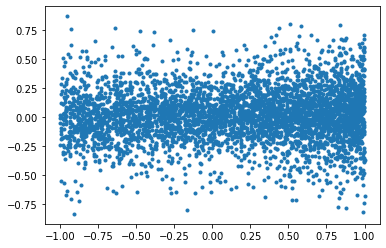

In [176]:
plt.plot(fam_signal_corrs, fam_noise_corrs, '.')

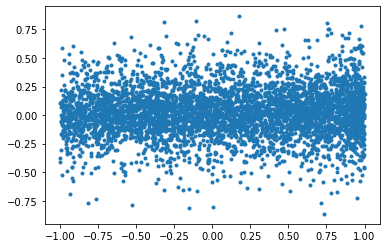

In [177]:
plt.plot(unfam_signal_corrs, unfam_noise_corrs, '.')

In [178]:
nas = np.logical_or(np.isnan(fam_signal_corrs), np.isnan(fam_noise_corrs))
print(pearsonr(fam_signal_corrs[~nas], fam_noise_corrs[~nas]))

(0.05728523731617215, 0.00015103690171211164)


In [179]:
nas = np.logical_or(np.isnan(unfam_signal_corrs), np.isnan(unfam_noise_corrs))
print(pearsonr(unfam_signal_corrs[~nas], unfam_noise_corrs[~nas]))

(0.04329446223104834, 0.0034540037545819427)


(array([ 81.,  96., 119.,  90., 109.,  97., 115., 119., 108., 112., 125.,
        113., 130., 119., 105., 128., 104., 130., 139., 119., 125., 127.,
        150., 144., 147., 151., 152., 167., 184., 180., 182., 221., 252.,
        268., 342.]),
 array([-0.99920011, -0.9420836 , -0.88496708, -0.82785057, -0.77073406,
        -0.71361755, -0.65650104, -0.59938453, -0.54226802, -0.48515151,
        -0.42803499, -0.37091848, -0.31380197, -0.25668546, -0.19956895,
        -0.14245244, -0.08533593, -0.02821942,  0.0288971 ,  0.08601361,
         0.14313012,  0.20024663,  0.25736314,  0.31447965,  0.37159616,
         0.42871268,  0.48582919,  0.5429457 ,  0.60006221,  0.65717872,
         0.71429523,  0.77141174,  0.82852825,  0.88564477,  0.94276128,
         0.99987779]),
 <a list of 35 Patch objects>)

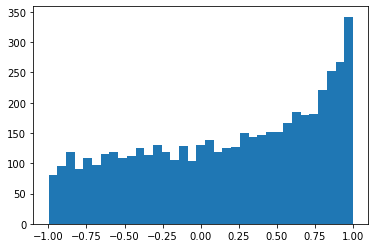

In [180]:
plt.hist(fam_signal_corrs, bins=35)

(array([102., 114., 116.,  99., 130., 152., 118., 129., 144., 131., 140.,
        156., 155., 128., 141., 148., 123., 156., 124., 137., 136., 139.,
        148., 121., 149., 149., 147., 139., 166., 151., 152., 155., 188.,
        217., 250.]),
 array([-0.99929848, -0.94217932, -0.88506016, -0.82794099, -0.77082183,
        -0.71370267, -0.65658351, -0.59946435, -0.54234518, -0.48522602,
        -0.42810686, -0.3709877 , -0.31386853, -0.25674937, -0.19963021,
        -0.14251105, -0.08539189, -0.02827272,  0.02884644,  0.0859656 ,
         0.14308476,  0.20020393,  0.25732309,  0.31444225,  0.37156141,
         0.42868058,  0.48579974,  0.5429189 ,  0.60003806,  0.65715722,
         0.71427639,  0.77139555,  0.82851471,  0.88563387,  0.94275304,
         0.9998722 ]),
 <a list of 35 Patch objects>)

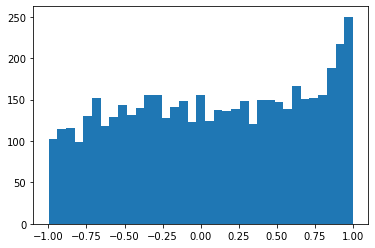

In [181]:
plt.hist(unfam_signal_corrs, bins=35)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  3.,   3.,   6.,  14.,  13.,  20.,  24.,  27.,  45.,  62.,  71.,
        132., 170., 231., 311., 356., 449., 437., 431., 409., 291., 213.,
        201., 133.,  95.,  63.,  38.,  41.,  30.,  23.,  11.,   7.,   7.,
          3.,   1.]),
 array([-0.83389342, -0.78530684, -0.73672026, -0.68813368, -0.6395471 ,
        -0.59096052, -0.54237394, -0.49378736, -0.44520078, -0.3966142 ,
        -0.34802762, -0.29944104, -0.25085446, -0.20226788, -0.1536813 ,
        -0.10509472, -0.05650814, -0.00792156,  0.04066502,  0.0892516 ,
         0.13783818,  0.18642476,  0.23501134,  0.28359792,  0.3321845 ,
         0.38077109,  0.42935767,  0.47794425,  0.52653083,  0.57511741,
         0.62370399,  0.67229057,  0.72087715,  0.76946373,  0.81805031,
         0.86663689]),
 <a list of 35 Patch objects>)

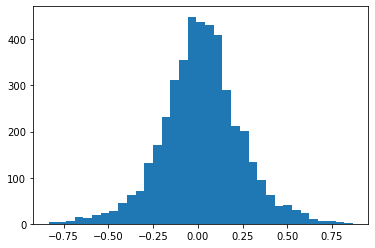

In [182]:
plt.hist(fam_noise_corrs, bins=35)

(array([  1.,   5.,   2.,   3.,   8.,  13.,  13.,  24.,  33.,  53.,  78.,
         92., 134., 220., 275., 398., 449., 485., 488., 451., 365., 275.,
        186., 148., 108.,  68.,  63.,  40.,  31.,  19.,  10.,  10.,   7.,
          2.,   3.]),
 array([-0.86509557, -0.81565399, -0.76621242, -0.71677084, -0.66732927,
        -0.61788769, -0.56844612, -0.51900454, -0.46956297, -0.42012139,
        -0.37067982, -0.32123824, -0.27179667, -0.22235509, -0.17291352,
        -0.12347194, -0.07403037, -0.02458879,  0.02485278,  0.07429436,
         0.12373593,  0.17317751,  0.22261908,  0.27206066,  0.32150224,
         0.37094381,  0.42038539,  0.46982696,  0.51926854,  0.56871011,
         0.61815169,  0.66759326,  0.71703484,  0.76647641,  0.81591799,
         0.86535956]),
 <a list of 35 Patch objects>)

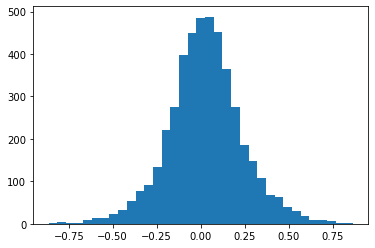

In [183]:
plt.hist(unfam_noise_corrs, bins=35)

In [184]:
np.nanmean(fam_noise_corrs)

0.02021313860064241

In [185]:
np.nanmean(unfam_noise_corrs)

0.026627832779421413

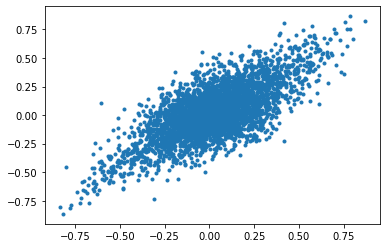

In [186]:
plt.plot(fam_noise_corrs, unfam_noise_corrs, '.')

In [155]:
test = get_stim_zscores(spikes, trials, good_clusters, 'P_40k', fs)

In [156]:
test.shape

(101, 20)

In [188]:
stim_subintervals = np.linspace(0, 1, 7)
subint_noisecorrs = []
for (a, b) in tqdm(zip(stim_subintervals[:-1], stim_subintervals[1:])):
    subint_zscores = get_all_stim_zscores(spikes, trials, good_clusters, fs, interval=[a,b])
    subint_noisecorrs.append(get_all_stim_avg_noise_correlation(subint_zscores, good_clusters))

0it [00:00, ?it/s]

Uh Oh... standard deviation very small
Cluster: 36 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 47 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 66 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 67 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 71 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 76 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 80 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 83 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 84 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 95 Sti

Uh Oh... standard deviation very small
Cluster: 118 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 22 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 23 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 35 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 36 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 47 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 61 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 66 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 67 S


0it [00:00, ?it/s]
238it [00:00, 2370.54it/s]


Uh Oh... standard deviation very small
Cluster: 126 Stimulus: P_40k mu: 0.0 sigma: 0.0


485it [00:00, 2397.32it/s]
722it [00:00, 2388.34it/s]
967it [00:00, 2405.27it/s]
1216it [00:00, 2428.46it/s]
1462it [00:00, 2435.50it/s]
1773it [00:00, 2602.43it/s]
2051it [00:00, 2651.40it/s]
2305it [00:00, 2596.26it/s]
2643it [00:01, 2789.85it/s]
2938it [00:01, 2835.21it/s]
3221it [00:01, 2819.55it/s]
3503it [00:01, 2761.74it/s]
3825it [00:01, 2884.53it/s]
4204it [00:01, 3105.97it/s]
4584it [00:01, 3285.84it/s]
5050it [00:01, 2856.84it/s]
1it [00:37, 37.73s/it]

Uh Oh... standard deviation very small
Cluster: 22 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 36 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 46 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 47 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 55 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 61 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 67 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 71 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 74 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 76 Sti

Uh Oh... standard deviation very small
Cluster: 55 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 61 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 66 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 67 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 71 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 74 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 83 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 101 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 118 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 36 Stimulus: P_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 


0it [00:00, ?it/s]
232it [00:00, 2313.37it/s]
470it [00:00, 2332.80it/s]
700it [00:00, 2320.02it/s]
936it [00:00, 2329.60it/s]
1178it [00:00, 2353.28it/s]
1434it [00:00, 2411.08it/s]
1714it [00:00, 2515.77it/s]
1976it [00:00, 2545.46it/s]
2247it [00:00, 2592.09it/s]
2558it [00:01, 2727.91it/s]
2857it [00:01, 2799.77it/s]
3135it [00:01, 2775.71it/s]
3412it [00:01, 2740.14it/s]
3686it [00:01, 2734.93it/s]
3990it [00:01, 2817.93it/s]
4275it [00:01, 2827.24it/s]
4558it [00:01, 2785.47it/s]
5050it [00:01, 2653.53it/s]
2it [01:16, 38.06s/it]

Uh Oh... standard deviation very small
Cluster: 36 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 66 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 67 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 71 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 76 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 78 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 83 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 84 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 92 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 102 St

Uh Oh... standard deviation very small
Cluster: 83 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 95 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 3 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 9 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 22 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 23 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 30 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 36 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 62 Stim


0it [00:00, ?it/s]
252it [00:00, 2515.65it/s]
487it [00:00, 2460.48it/s]
799it [00:00, 2625.98it/s]
1085it [00:00, 2690.91it/s]
1348it [00:00, 2671.49it/s]
1641it [00:00, 2742.31it/s]
1888it [00:00, 2653.19it/s]
2145it [00:00, 2627.26it/s]
2396it [00:00, 2588.00it/s]
2677it [00:01, 2650.56it/s]
2951it [00:01, 2675.15it/s]
3215it [00:01, 2660.15it/s]
3479it [00:01, 2593.73it/s]
3763it [00:01, 2662.53it/s]
4062it [00:01, 2750.81it/s]
4414it [00:01, 2943.55it/s]
4713it [00:01, 2913.78it/s]
5050it [00:01, 2737.05it/s]
3it [01:55, 38.20s/it]

Uh Oh... standard deviation very small
Cluster: 6 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 19 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 75 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 83 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 19 Stimulus: J_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 36 Stimulus: J_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: J_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 47 Stimulus: J_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Sti

Uh Oh... standard deviation very small
Cluster: 84 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 92 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 95 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 103 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 15 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 19 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 36 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 38 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 47 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 S


0it [00:00, ?it/s]
243it [00:00, 2420.01it/s]

Uh Oh... standard deviation very small
Cluster: 126 Stimulus: P_40k mu: 0.0 sigma: 0.0



495it [00:00, 2445.83it/s]
735it [00:00, 2430.46it/s]
1008it [00:00, 2511.12it/s]
1268it [00:00, 2535.55it/s]
1596it [00:00, 2719.69it/s]
1845it [00:00, 2645.16it/s]
2093it [00:00, 2583.96it/s]
2341it [00:00, 2544.98it/s]
2641it [00:01, 2666.04it/s]
2945it [00:01, 2765.13it/s]
3228it [00:01, 2784.18it/s]
3506it [00:01, 2652.82it/s]
3791it [00:01, 2707.41it/s]
4063it [00:01, 2650.03it/s]
4370it [00:01, 2762.85it/s]
4649it [00:01, 2733.10it/s]
5050it [00:01, 2688.94it/s]
4it [02:33, 38.28s/it]

Uh Oh... standard deviation very small
Cluster: 7 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 19 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 20 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 22 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 27 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 33 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 34 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 35 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 36 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 47 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 55 Stim

Uh Oh... standard deviation very small
Cluster: 67 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 71 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 75 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 76 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 83 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 92 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 99 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 103 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 112 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 2 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 7 St

Uh Oh... standard deviation very small
Cluster: 49 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 55 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 71 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 74 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 75 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 76 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 82 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 83 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 84 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 86 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 92 Sti


0it [00:00, ?it/s]
305it [00:00, 3045.62it/s]


Uh Oh... standard deviation very small
Cluster: 126 Stimulus: P_40k mu: 0.0 sigma: 0.0


625it [00:00, 3089.74it/s]
930it [00:00, 3076.20it/s]
1242it [00:00, 3088.29it/s]
1656it [00:00, 3341.76it/s]
2022it [00:00, 3428.92it/s]
2339it [00:00, 3345.57it/s]
2707it [00:00, 3437.03it/s]
3037it [00:00, 3353.84it/s]
3366it [00:01, 3331.78it/s]
3693it [00:01, 3290.40it/s]
4050it [00:01, 3368.63it/s]
4409it [00:01, 3431.76it/s]
5050it [00:01, 3332.44it/s]
5it [03:09, 37.60s/it]

Uh Oh... standard deviation very small
Cluster: 3 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 15 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 19 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 27 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 33 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 36 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 41 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 42 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 46 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 47 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 55 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 60 Stim

Uh Oh... standard deviation very small
Cluster: 67 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 74 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 75 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 83 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 92 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 95 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 103 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 126 Stimulus: M_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 9 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 15 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 19 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 22 St


0it [00:00, ?it/s]
280it [00:00, 2791.54it/s]


Uh Oh... standard deviation very small
Cluster: 126 Stimulus: P_40k mu: 0.0 sigma: 0.0


539it [00:00, 2727.12it/s]
804it [00:00, 2701.19it/s]
1086it [00:00, 2733.13it/s]
1368it [00:00, 2757.27it/s]
1726it [00:00, 2961.35it/s]
2043it [00:00, 3020.72it/s]
2342it [00:00, 3009.97it/s]
2683it [00:00, 3118.35it/s]
2987it [00:01, 3076.17it/s]
3304it [00:01, 3101.50it/s]
3611it [00:01, 2966.23it/s]
3907it [00:01, 2960.64it/s]
4204it [00:01, 2960.81it/s]
4558it [00:01, 3111.32it/s]
5050it [00:01, 2978.43it/s]
6it [03:46, 37.82s/it]


In [189]:
subint_noisecorrs[0].shape

(5050,)

In [200]:
nc_v_time = np.array([(i, x) for i, y in enumerate(subint_noisecorrs) for x in y ])
mean_nc_v_time = np.array([(i, np.nanmean(x)) for i, x in enumerate(subint_noisecorrs)])
std_nc_v_time = np.array([(i, np.nanstd(x)) for i, x in enumerate(subint_noisecorrs)])

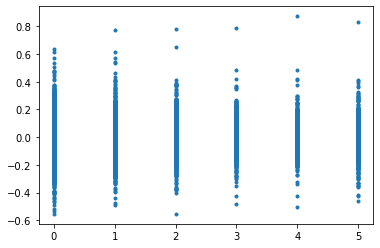

In [194]:
plt.plot(nc_v_time[:, 0],  nc_v_time[:, 1], '.')

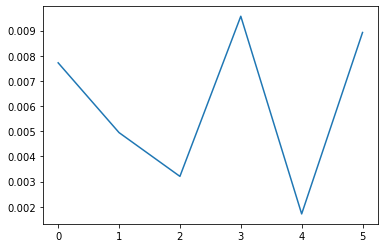

In [202]:
plt.plot(mean_nc_v_time[:, 0], mean_nc_v_time[:, 1])